# Gaussian Transport Test

Given two Gaussian distributions, we randomly sample points from the start distribution and the goal distribution and find the best matching pairs between the nodes

## Sampling

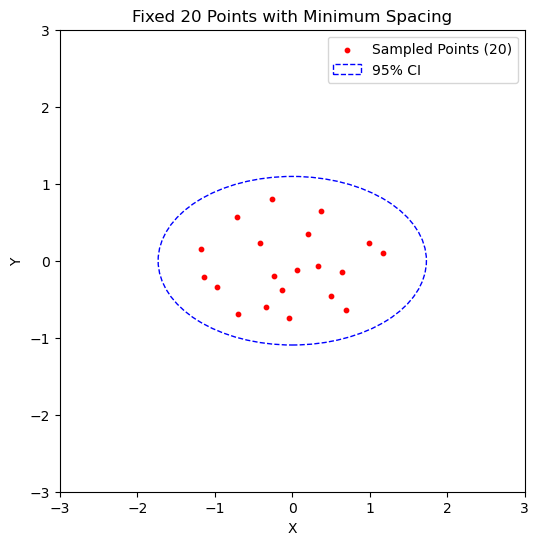

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

# Define Gaussian parameters
mean = [0, 0]  # Center of the Gaussian
cov = [[0.5, 0], [0, 0.2]]  # Isotropic Gaussian (Circular shape)

# Parameters
desired_samples = 20  # Fixed number of points to generate
num_candidates = 500 # Large candidate pool to ensure enough valid samples
min_spacing = 0.2  # Minimum allowed distance between points

# Generate candidate samples from 2D Gaussian
candidates = np.random.multivariate_normal(mean, cov, num_candidates)

# Compute 95% confidence interval boundary (Mahalanobis distance)
n_std = 2.4477  # Corresponds to 95% confidence
inv_cov = np.linalg.inv(cov)

# Function to check if a point is inside the confidence ellipse
def is_within_confidence_interval(point, mean, inv_cov, n_std):
    delta = point - mean
    mahalanobis_distance = np.sqrt(delta.T @ inv_cov @ delta)
    return mahalanobis_distance <= n_std

# Enforce spacing using KDTree while ensuring a fixed number of points
accepted_points1 = []
tree = KDTree([[0, 0]])

for point in candidates:
    if len(accepted_points1) >= desired_samples:  # Stop when we reach the desired number
        break
    if is_within_confidence_interval(point, mean, inv_cov, n_std):
        if len(accepted_points1) == 0 or tree.query(point)[0] > min_spacing:
            accepted_points1.append(point)
            tree = KDTree(accepted_points1)  # Update KDTree with new point

accepted_points1 = np.array(accepted_points1)

# Plot results
plt.figure(figsize=(6, 6))
plt.scatter(accepted_points1[:, 0], accepted_points1[:, 1], color="red", s=10, label=f"Sampled Points ({desired_samples})")

# Draw the 95% confidence interval ellipse
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(mean, cov, ax, n_std=2.4477, **kwargs):
    """Draws an ellipse representing the n_std confidence interval of a Gaussian."""
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    width, height = 2 * n_std * np.sqrt(eigvals)
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, **kwargs)
    ax.add_patch(ellipse)

ax = plt.gca()
confidence_ellipse(mean, cov, ax, edgecolor='blue', facecolor='none', linestyle='dashed', label='95% CI')

plt.xlabel("X")
plt.ylabel("Y")
plt.title(f"Fixed {desired_samples} Points with Minimum Spacing")
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.legend()
plt.show()


## One to One

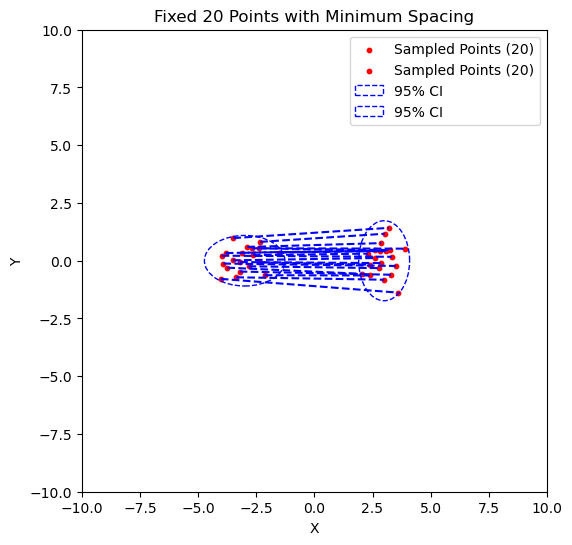

In [1]:
import numpy as np
from scipy.spatial import KDTree
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from matplotlib import pyplot as plt

mean1 = [-3, 0]
cov1 = [[0.5, 0], [0, 0.2]]
mean2 = [3, 0]
cov2 = [[0.2, 0], [0, 0.5]]

desired_samples = 20  # Fixed number of points to generate
num_candidates = 500 # Large candidate pool to ensure enough valid samples
min_spacing = 0.2  # Minimum allowed distance between points

# Sample from two Gaussians
candidates1 = np.random.multivariate_normal(mean1, cov1, num_candidates)
candidates2 = np.random.multivariate_normal(mean2, cov2, num_candidates)

# Compute 95% confidence interval boundary (Mahalanobis distance)
n_std = 2.4477  # Corresponds to 95% confidence
inv_cov1 = np.linalg.inv(cov1)
inv_cov2 = np.linalg.inv(cov2)

# Enforce spacing using KDTree while ensuring a fixed number of points
accepted_points1 = [] 
accepted_points2 = []

tree1 = KDTree([mean1]) # always keep the mean
tree2 = KDTree([mean2]) # always keep the mean

# Function to check if a point is inside the confidence ellipse
def is_within_confidence_interval(point, mean, inv_cov, n_std):
    delta = point - mean
    mahalanobis_distance = np.sqrt(delta.T @ inv_cov @ delta)
    return mahalanobis_distance <= n_std

for point in candidates1:
    if len(accepted_points1) >= desired_samples:  # Stop when we reach the desired number
        break
    if is_within_confidence_interval(point, mean1, inv_cov1, n_std):
        if len(accepted_points1) == 0 or tree.query(point)[0] > min_spacing:
            accepted_points1.append(point)
            tree = KDTree(accepted_points1)  # Update KDTree with new point

for point in candidates2:
    if len(accepted_points2) >= desired_samples:  # Stop when we reach the desired number
        break
    if is_within_confidence_interval(point, mean2, inv_cov2, n_std):
        if len(accepted_points2) == 0 or tree.query(point)[0] > min_spacing:
            accepted_points2.append(point)
            tree = KDTree(accepted_points2)  # Update KDTree with new point

accepted_points1 = np.array(accepted_points1)
accepted_points2 = np.array(accepted_points2)

def match_points(accepted_points1, accepted_points2):
    dist_matrix = cdist(accepted_points1, accepted_points2)
    row_ind, col_ind = linear_sum_assignment(dist_matrix)
    matching_points1 = accepted_points1[row_ind]
    matching_points2 = accepted_points2[col_ind]
    return matching_points1, matching_points2

# Plot results
plt.figure(figsize=(6, 6))
plt.scatter(accepted_points1[:, 0], accepted_points1[:, 1], color="red", s=10, label=f"Sampled Points ({desired_samples})")
plt.scatter(accepted_points2[:, 0], accepted_points2[:, 1], color="red", s=10, label=f"Sampled Points ({desired_samples})")

# Find min sum of cost matching

# Draw the 95% confidence interval ellipse
from matplotlib.patches import Ellipse

def confidence_ellipse(mean, cov, ax, n_std=2.4477, **kwargs):
    """Draws an ellipse representing the n_std confidence interval of a Gaussian."""
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    width, height = 2 * n_std * np.sqrt(eigvals)
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, **kwargs)
    ax.add_patch(ellipse)

ax = plt.gca()
confidence_ellipse(mean1, cov1, ax, edgecolor='blue', facecolor='none', linestyle='dashed', label='95% CI')
confidence_ellipse(mean2, cov2, ax, edgecolor='blue', facecolor='none', linestyle='dashed', label='95% CI')

# Draw lines connecting matched points

matching_points1, matching_points2 = match_points(accepted_points1, accepted_points2)
for p1, p2 in zip(matching_points1, matching_points2):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color="blue", linestyle="--")

plt.xlabel("X")
plt.ylabel("Y")
plt.title(f"Fixed {desired_samples} Points with Minimum Spacing")
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.legend()
plt.show()

# Create gif of moving points from 1 to 2
import matplotlib.animation as animation


## Split

(20, 2)


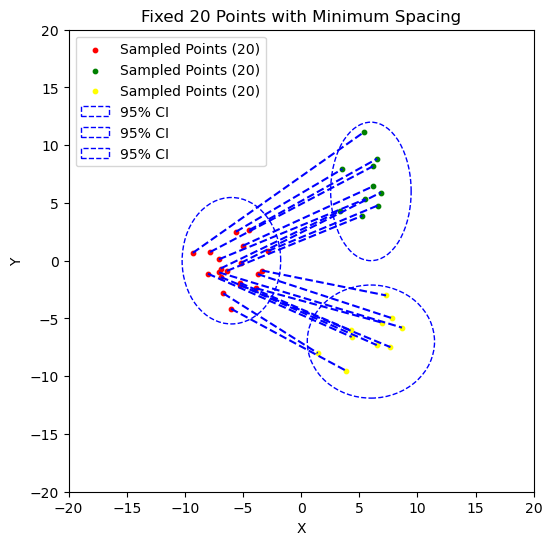

In [2]:
# One Gaussian to multiple Gaussians

min_spacing = 0.001


mean1 = [-6, 0]
mean2 = [6, 6]
mean3 = [6, -7]

cov1 = [[3, 0], [0, 5]]
cov2 = [[2, 0], [0, 6]]
cov3 = [[5, 0], [0, 4]]

num_start = [20]
num_goal = [10, 10]

def sample_points(mean, cov, num_points, min_spacing, candidates=1000, n_std=2.4477):

  # corresponds to 95% confidence
    accepted_points = []
    tree = KDTree([mean])
    inv_cov = np.linalg.inv(cov)
    candidates = np.random.multivariate_normal(mean, cov, candidates)
    for point in candidates:
        if len(accepted_points) >= num_points:  # stop when we reach the desired number
            break
        if is_within_confidence_interval(point, mean, inv_cov, n_std):
            if tree.query(point)[0] > min_spacing:
                accepted_points.append(point)
                tree = KDTree(accepted_points)  # update kdtree with new point
    return np.array(accepted_points)

samples1 = sample_points(mean1, cov1, num_start[0], min_spacing)
samples2 = sample_points(mean2, cov2, num_goal[0], min_spacing)
samples3 = sample_points(mean3, cov3, num_goal[1], min_spacing)

samples= np.concatenate([samples2, samples3], axis=0)
print(samples.shape)

# Assign points from start to goals based on distance between means of goals and target number of points
m1, m2 = match_points(samples1, samples)


plt.figure(figsize=(6, 6))
plt.scatter(samples1[:, 0], samples1[:, 1], color="red", s=10, label=f"Sampled Points ({desired_samples})")
plt.scatter(samples2[:, 0], samples2[:, 1], color="green", s=10, label=f"Sampled Points ({desired_samples})")
plt.scatter(samples3[:, 0], samples3[:, 1], color="yellow", s=10, label=f"Sampled Points ({desired_samples})")

# Find min sum of cost matching

# Draw the 95% confidence interval ellipse
from matplotlib.patches import Ellipse

def confidence_ellipse(mean, cov, ax, n_std=2.4477, **kwargs):
    """Draws an ellipse representing the n_std confidence interval of a Gaussian."""
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    width, height = 2 * n_std * np.sqrt(eigvals)
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, **kwargs)
    ax.add_patch(ellipse)

ax = plt.gca()
confidence_ellipse(mean1, cov1, ax, edgecolor='blue', facecolor='none', linestyle='dashed', label='95% CI')
confidence_ellipse(mean2, cov2, ax, edgecolor='blue', facecolor='none', linestyle='dashed', label='95% CI')
confidence_ellipse(mean3, cov3, ax, edgecolor='blue', facecolor='none', linestyle='dashed', label='95% CI')

# Draw lines connecting matched points

matching_points1, matching_points2 = match_points(samples1, samples)
for p1, p2 in zip(matching_points1, matching_points2):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color="blue", linestyle="--")

plt.xlabel("X")
plt.ylabel("Y")
plt.title(f"Fixed {desired_samples} Points with Minimum Spacing")
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.legend()
plt.show()

## Merge

(20, 2)


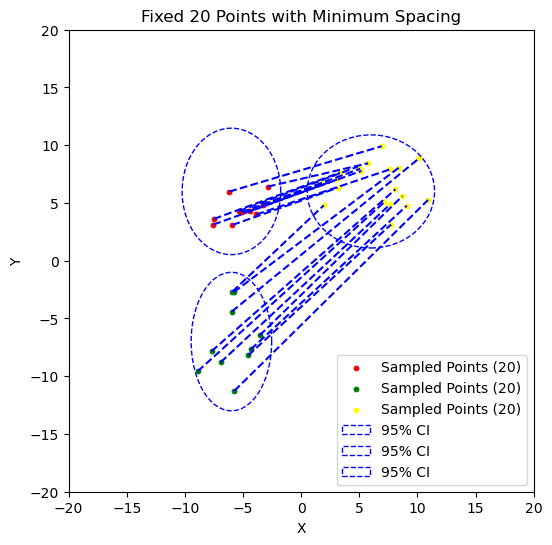

In [3]:

# One Gaussian to multiple Gaussians

min_spacing = 0.001


mean1 = [-6, 6]
mean2 = [-6, -7]
mean3 = [6, 6]

cov1 = [[3, 0], [0, 5]]
cov2 = [[2, 0], [0, 6]]
cov3 = [[5, 0], [0, 4]]

num_start = [10, 10]
num_goal = [20]

def sample_points(mean, cov, num_points, min_spacing, candidates=1000, n_std=2.4477):

  # Corresponds to 95% confidence
    accepted_points = []
    tree = KDTree([mean])
    inv_cov = np.linalg.inv(cov)
    candidates = np.random.multivariate_normal(mean, cov, candidates)
    for point in candidates:
        if len(accepted_points) >= num_points:  # Stop when we reach the desired number
            break
        if is_within_confidence_interval(point, mean, inv_cov, n_std):
            if tree.query(point)[0] > min_spacing:
                accepted_points.append(point)
                tree = KDTree(accepted_points)  # Update KDTree with new point
    return np.array(accepted_points)

samples1 = sample_points(mean1, cov1, num_start[0], min_spacing)
samples2 = sample_points(mean2, cov2, num_start[1], min_spacing)
samples3 = sample_points(mean3, cov3, num_goal[0], min_spacing)

samples= np.concatenate([samples1, samples2], axis=0)
print(samples.shape)

# Assign points from start to goals based on distance between means of goals and target number of points
m1, m2 = match_points(samples, samples3)


plt.figure(figsize=(6, 6))
plt.scatter(samples1[:, 0], samples1[:, 1], color="red", s=10, label=f"Sampled Points ({desired_samples})")
plt.scatter(samples2[:, 0], samples2[:, 1], color="green", s=10, label=f"Sampled Points ({desired_samples})")
plt.scatter(samples3[:, 0], samples3[:, 1], color="yellow", s=10, label=f"Sampled Points ({desired_samples})")

# Find min sum of cost matching

# Draw the 95% confidence interval ellipse
from matplotlib.patches import Ellipse

def confidence_ellipse(mean, cov, ax, n_std=2.4477, **kwargs):
    """Draws an ellipse representing the n_std confidence interval of a Gaussian."""
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    width, height = 2 * n_std * np.sqrt(eigvals)
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, **kwargs)
    ax.add_patch(ellipse)

ax = plt.gca()
confidence_ellipse(mean1, cov1, ax, edgecolor='blue', facecolor='none', linestyle='dashed', label='95% CI')
confidence_ellipse(mean2, cov2, ax, edgecolor='blue', facecolor='none', linestyle='dashed', label='95% CI')
confidence_ellipse(mean3, cov3, ax, edgecolor='blue', facecolor='none', linestyle='dashed', label='95% CI')

# Draw lines connecting matched points

matching_points1, matching_points2 = match_points(samples, samples3)
for p1, p2 in zip(matching_points1, matching_points2):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color="blue", linestyle="--")

plt.xlabel("X")
plt.ylabel("Y")
plt.title(f"Fixed {desired_samples} Points with Minimum Spacing")
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.legend()
plt.show()

/tmp/ipykernel_142059/4237917759.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


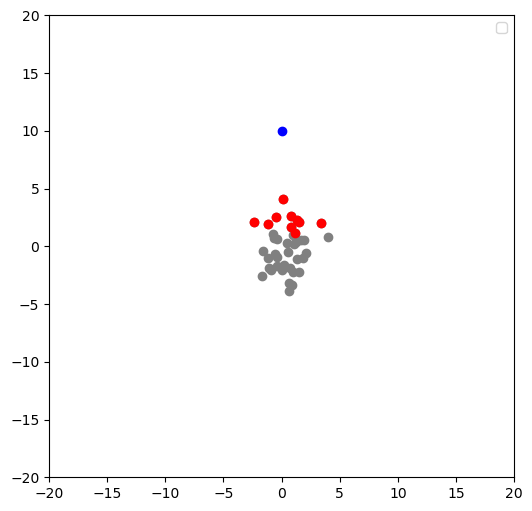

In [4]:
def is_within_confidence_interval(point, mean, inv_cov, n_std):
    delta = point - mean
    mahalanobis_distance = np.sqrt(delta.T @ inv_cov @ delta)
    return mahalanobis_distance <= n_std

def choose_unassigned_agents(agent_locations, mean, num_agents):
    """
        Choose agents in node that is not assigned and closest to the next node
    """
    # Find agents that are closest to the next node
    sorted_agents = np.argsort(np.linalg.norm(agent_locations - mean, axis=1)) # Take num_agents closest agents
    agents = sorted_agents[:num_agents]
    return np.array([agent_locations[agent] for agent in agents])

def sample_points(mean, cov, num_points, min_spacing, candidates=1000, n_std=2.4477):

  # corresponds to 95% confidence
    accepted_points = []
    tree = KDTree([mean])
    inv_cov = np.linalg.inv(cov)
    candidates = np.random.multivariate_normal(mean, cov, candidates)
    for point in candidates:
        if len(accepted_points) >= num_points:  # stop when we reach the desired number
            break
        if is_within_confidence_interval(point, mean, inv_cov, n_std):
            if tree.query(point)[0] > min_spacing:
                accepted_points.append(point)
                tree = KDTree(accepted_points)  # update kdtree with new point
    return np.array(accepted_points)

mean = [0, 0]
cov = [[3, 0], [0, 4]]

goal = [0, 10]

samples = sample_points(mean, cov, 40, min_spacing)

locs = choose_unassigned_agents(samples, goal, 10)

plt.figure(figsize=(6, 6))
ax = plt.gca()

plt.scatter(samples[:, 0], samples[:, 1], color='gray')
plt.scatter(locs[:, 0], locs[:, 1], color="red")
plt.plot(goal[0], goal[1], "bo")

plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.legend()
plt.show()
